In [ ]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal


In [ ]:
def load_mono(path):
    x, sr = sf.read(path, always_2d=True)
    x = x.mean(axis=1)  # mono
    x = x.astype(np.float64)
    x -= x.mean()
    return x, sr

def align_by_xcorr(a, b, max_lag_s=0.2, sr=48000):
    max_lag = int(max_lag_s * sr)
    c = correlate(b, a, mode="full")  # correlation to align b to a
    mid = len(c)//2
    cwin = c[mid-max_lag:mid+max_lag+1]
    lag = np.argmax(cwin) - max_lag  # +lag means b is delayed vs a
    if lag > 0:
        b_al = b[lag:]
        a_al = a[:len(b_al)]
    elif lag < 0:
        a_al = a[-lag:]
        b_al = b[:len(a_al)]
    else:
        n = min(len(a), len(b))
        a_al, b_al = a[:n], b[:n]
    return a_al, b_al, lag

def rms_norm(x, eps=1e-12):
    return x / (np.sqrt(np.mean(x**2)) + eps)

def relative_transfer_fingerprint(a, b, sr, nperseg=4096, fmin=80, fmax=8000):
    # spectra
    f, S_aa = welch(a, fs=sr, nperseg=nperseg)
    _, S_ba = csd(b, a, fs=sr, nperseg=nperseg)
    _, coh  = coherence(b, a, fs=sr, nperseg=nperseg)

    H = S_ba / (S_aa + 1e-18)
    mag_db = 20*np.log10(np.abs(H) + 1e-18)

    # band-limit + coherence mask
    mask = (f >= fmin) & (f <= fmax) & (coh >= 0.5)
    f2 = f[mask]
    mag2 = mag_db[mask]
    coh2 = coh[mask]

    # downsample into fixed-length fingerprint via weighted binning
    nbins = 40
    edges = np.linspace(fmin, fmax, nbins+1)
    fp = np.zeros(nbins)
    for i in range(nbins):
        m = (f2 >= edges[i]) & (f2 < edges[i+1])
        if np.any(m):
            w = coh2[m]
            fp[i] = np.sum(w * mag2[m]) / (np.sum(w) + 1e-12)
        else:
            fp[i] = 0.0

    # normalize fingerprint (remove overall tilt/offset)
    fp = fp - np.mean(fp)
    fp = fp / (np.std(fp) + 1e-12)

    return fp, (f, mag_db, coh)

def fingerprint_distance(fp1, fp2):
    # cosine distance
    num = np.dot(fp1, fp2)
    den = (np.linalg.norm(fp1) * np.linalg.norm(fp2) + 1e-12)
    return 1 - (num/den)


In [ ]:
path1 = r'data\1m straight pipe y branch\clogged pipe, no noisy first obs.wav'
path2 = r'data\1m straight pipe y branch\free pipe, no noisy first obs.wav'
    
a, sr1 = load_mono(path1)
b, sr2 = load_mono(path2)
t = np.arange(len(x)) / sr




sample_rate: 96000
shape: (962140, 2) (samples, channels)
duration_s: 10.022291666666666


Left: peak=0.1067 rms=0.0220 dc=-0.000025 clipped_frac=0.000000
Right: peak=0.1256 rms=0.0286 dc=-0.000025 clipped_frac=0.000000


Using average of Left and Right channels as mono signal


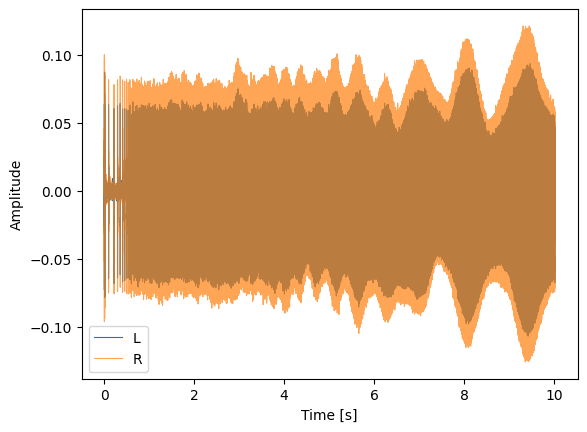

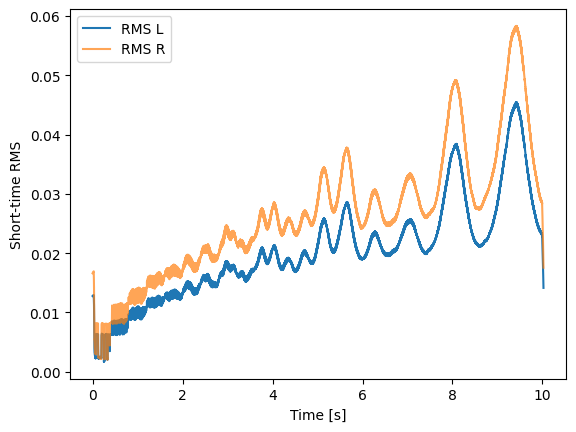

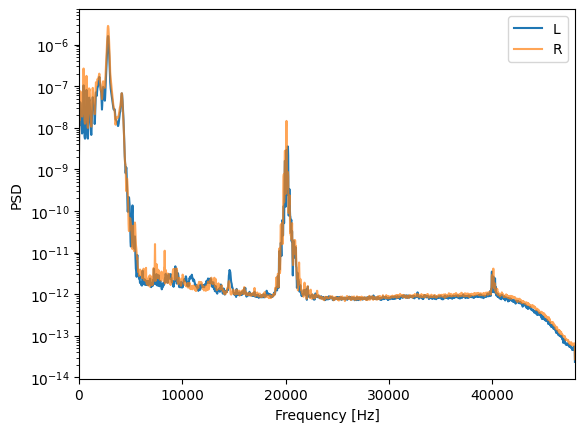

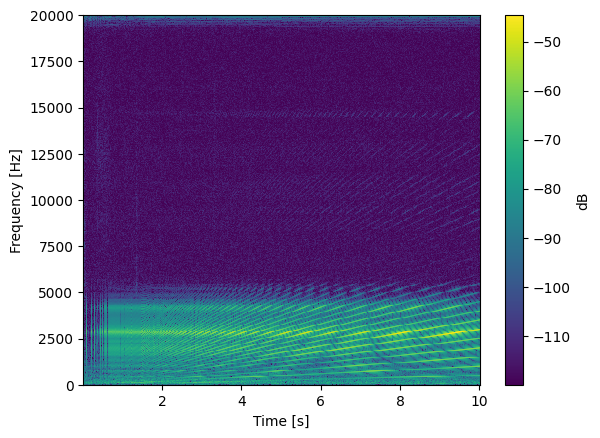

L-R balance [dB]: -2.3045939333882997
L/R correlation: 0.9648205451285801
Mid RMS: 0.02507171233751775
Side RMS: 0.0047097940123893645
Side/Mid ratio [dB]: -14.5236416585448


lag_samples: -801
fingerprint_len: 40
